<a href="https://colab.research.google.com/github/sg-peytrignet/algeria24-training/blob/main/2_visibility_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visibility analysis

## Setting up our environment

In this section, we're installing and importing all the libraries we'll need for our analysis. We're using libraries for data manipulation (pandas, numpy), geospatial analysis (geopandas, shapely), elevation data handling (SRTM), and visualization (plotly, folium). These tools will help us analyze and visualize the line-of-sight visibility between schools and cell sites.

In [1]:
!pip install pycountry python-srtm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.9 MB/s eta 0:00:00


In [2]:
# Standard library imports
import os
from pathlib import Path
from urllib import request
import requests

# Data manipulation
import numpy as np
import pandas as pd

# Geospatial data handling
import pycountry
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import LineString
from srtm.height_map_collection import Srtm1HeightMapCollection

# Visualization and plotting
import plotly.graph_objects as go
import folium
import seaborn as sns
import matplotlib.pyplot as plt

# Progress display
from tqdm import tqdm

# Interactive display and widgets
import ipywidgets as widgets
from IPython.display import display

The option `display_folium` controls whether to display interactive maps, which can be heavy and prevent the markdown file from displaying correctly.

In [3]:
display_folium = True

## Set analysis parameters

Here we create an interactive form that allows us to adjust important parameters for our analysis. You need to click play button of the controls cell each time you change the parameters.

- Country selection (where we'll analyze tower visibility)
- School building height (how tall the school antenna would be)
- Tower height (how tall the radio tower antenna would be)
- Maximum cell site reach (how far to look for towers around each school)
- Number of visible towers to look for (number of searches)

In [4]:
# @title Parameters
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

item_layout2 = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

country = widgets.Dropdown(
    description='Country:',
    options=list(map(lambda x: x.name, pycountry.countries)),
    value='Algeria',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

school_building_height = widgets.FloatSlider(
    description='School Building Height (m):',
    min=0,
    max=100,
    step=1,
    value=15,
    layout=item_layout,
    style={'description_width': 'initial'}
)

tower_height = widgets.FloatSlider(
    description='Tower Height (m):',
    min=0,
    max=100,
    step=1,
    value=15,
    layout=item_layout,
    style={'description_width': 'initial'}
)

max_tower_reach = widgets.FloatSlider(
    description='Maximum Tower Reach (km):',
    min=0,
    max=100,
    step=1,
    value=35,
    layout=item_layout,
    style={'description_width': 'initial'}
)

n_visible = widgets.IntSlider(
    description='N Visible:',
    min=0,
    max=10,
    step=1,
    value=3,
    layout=item_layout
)

inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([country], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([school_building_height], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([tower_height], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([max_tower_reach, n_visible], layout=widgets.Layout(justify_content='space-between'))
    ]
)

display(inputs_layout)

<br>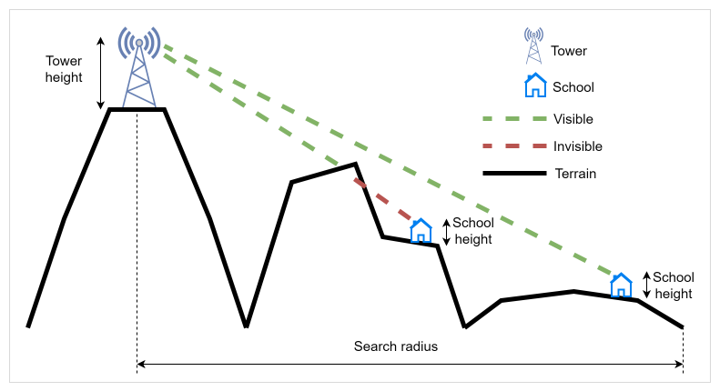
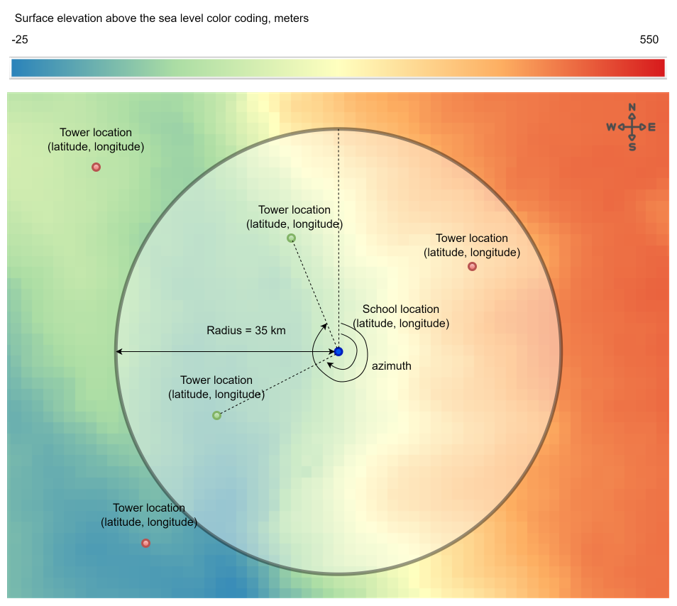

## Download school dataset

We're loading a dataset containing information about schools in Algeria. Each school has a unique identifier, its geographical coordinates (latitude and longitude), and a label indicating whether it's currently connected to the internet. The data is loaded into a GeoDataFrame, which is a special type of DataFrame that understands geographical data and can perform spatial operations.

The school data contains the following columns:

| Column            | Description                                             | Example                                    |
|-------------------|---------------------------------------------------------|--------------------------------------------|
| poi_id           | Unique school identifier (UUID)                         | "8dd444f0-2eb1-4d9a-bf57-f032e517683"      |
| dataset_id       | Source data collection identifier                       | "34500f3d-aec9-418b-81ff-1a77d23ba047"     |
| lat              | School's latitude coordinate                            | 31.949701                                   |
| lon              | School's longitude coordinate                           | 33.580467                                   |
| country_code     | Three-letter ISO country code                          | "DZA" (Algeria)                             |
| poi_type         | Type of point of interest                              | "school"                                    |
| is_connected     | Internet connectivity status                           | false                                       |
| connectivity_type| Type of internet connection if available               | NaN (Not Available)                         |
| has_electricity  | Electricity availability status                        | NaN (Not Available)                         |
| electricity_type | Type of electrical supply if available                 | NaN (Not Available)                         |
| label            | Category label for the point of interest               | "school"                                    |
| geometry         | Geographic point representation (lat/lon)              | "POINT (3.580467 31.949701)"               |


In [5]:
algeria_schools = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_schools.csv")

In [6]:
algeria_schools_gdf = gpd.GeoDataFrame(algeria_schools, geometry=gpd.points_from_xy(algeria_schools.lon, algeria_schools.lat), crs='EPSG:4326')

In [7]:
# We restrict the Analysis to the schools in the city of Algiers for demonstration purposes
subset_schools = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algiers_schools.csv")
algeria_schools_gdf = algeria_schools_gdf[algeria_schools_gdf['poi_id'].isin(subset_schools.id)]

In [8]:
algeria_schools_gdf.head()

,poi_id,dataset_id,lat,lon,country_code,poi_type,is_connected,connectivity_type,has_electricity,electricity_type,label,geometry
297,6e12069b-70af-4564-b1a5-ddd16b81e593,34500f3d-aec9-418b-81ff-1a77d23ba047,36.609594,3.542067,DZA,school,False,NaN,NaN,NaN,school,POINT (3.54207 36.60959)
298,45f0b8f3-b058-4fcb-9e03-de0df8428444,34500f3d-aec9-418b-81ff-1a77d23ba047,36.715343,3.426997,DZA,school,False,NaN,NaN,NaN,school,POINT (3.427 36.71534)
299,0dad48a7-65d2-4e91-81a6-f3043fe91b7d,34500f3d-aec9-418b-81ff-1a77d23ba047,36.690654,3.374367,DZA,school,False,NaN,NaN,NaN,school,POINT (3.37437 36.69065)
300,f8948230-43b0-40ba-842b-6928e04f025c,34500f3d-aec9-418b-81ff-1a77d23ba047,36.685188,3.365916,DZA,school,False,NaN,NaN,NaN,school,POINT (3.36592 36.68519)
301,dde74283-e2ad-4dae-b531-a6bbb5fb9d1e,34500f3d-aec9-418b-81ff-1a77d23ba047,36.722098,3.394928,DZA,school,False,NaN,NaN,NaN,school,POINT (3.39493 36.7221)


## Download cell site dataset

Similar to the school dataset, we're loading information about cell site locations. Each tower record includes its coordinates, a unique identifier, the technologies it supports, and antenna heights. This information is crucial for determining whether a cell site could potentially provide coverage to nearby schools.

The cell site data contains the following columns:


| Column                      | Description                                             | Example                                    |
|----------------------------|---------------------------------------------------------|--------------------------------------------|
| ict_id                     | Unique identifier for ICT infrastructure                | "ffc1a8b1-3f54-4692-9cc7-2249d9fbdbcc"    |
| dataset_id                 | Source data collection identifier                       | "baddd192-284a-4025-8a10-f00929f3456a"     |
| lat                        | Cell site's latitude coordinate                         | 36.738                                      |
| lon                        | Cell site's longitude coordinate                        | 2.9742                                      |
| radio_type                 | Mobile network generation                              | "4G"                                        |
| antenna_height             | Height of antenna in meters                            | 25                                          |
| backhaul_type             | Type of backhaul connection                            | NaN (Not Available)                         |
| backhaul_throughput_mbps   | Backhaul connection speed in Mbps                     | NaN (Not Available)                         |
| operator_name              | Name of telecom operator                              | NaN (Not Available)                         |
| azimuth_degrees           | Antenna direction in degrees                          | NaN (Not Available)                         |
| tower_height              | Total height of tower structure                       | NaN (Not Available)                         |
| geometry                   | Geographic point representation (lon/lat)              | "POINT (2.9742 36.738)"                    |

In [9]:
algeria_cellsites = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_cell_sites.csv")

In [10]:
algeria_cellsites_gdf = gpd.GeoDataFrame(algeria_cellsites, geometry=gpd.points_from_xy(algeria_cellsites.lon, algeria_cellsites.lat), crs='EPSG:4326')

In [11]:
algeria_cellsites_gdf.head()

,ict_id,dataset_id,lat,lon,radio_type,antenna_height,backhaul_type,backhaul_throughput_mbps,operator_name,azimuth_degrees,tower_height,geometry
0,ffc1a8b1-3f54-4692-9cc7-2249d9fbdbcc,baddd192-284a-4025-8a10-f00929f3456a,36.7380,2.9742,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.9742 36.738)
1,3e8514ad-abc8-4ed0-b80d-01ac43f80bdd,baddd192-284a-4025-8a10-f00929f3456a,36.7447,2.9742,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.9742 36.7447)
2,7517a4ca-33b8-4a15-bf03-119dc75f3871,baddd192-284a-4025-8a10-f00929f3456a,36.7453,2.9849,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.9849 36.7453)
3,ad795a2c-a08a-46f7-980e-e4fa98a32326,baddd192-284a-4025-8a10-f00929f3456a,36.7491,3.0012,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (3.0012 36.7491)
4,f9599329-bc4a-48ff-9085-deda962262e8,baddd192-284a-4025-8a10-f00929f3456a,36.7503,3.0027,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (3.0027 36.7503)


## Add heights to the school and cell site datasets

In this step, we're adding standardized heights to our datasets based on the parameters we set earlier. For schools, we assume all antennas would be mounted at the same height. For towers, we're setting a standard antenna height.

In [12]:
algeria_schools_gdf['height'] = school_building_height.value
algeria_cellsites_gdf["antenna_height"] = tower_height.value

## Create KD tree of towers for efficient nearest neighbor search

Here we create a KD-tree data structure to efficiently find nearby towers for each school. A KD-tree is like a sophisticated address book that organizes points in space so we can quickly find the closest ones to any location. This significantly speeds up our analysis by avoiding the need to check every tower for every school. This structure helps reduce the search time and is especially useful in high-dimensional spaces where traditional search methods can be slow.

In [13]:
kdtree = cKDTree(algeria_cellsites_gdf[['lon', 'lat']].values)

## Visibility analysis for one school

This section demonstrates the analysis process for a single school as an example:

1. We select one school from our dataset
2. Find all towers within our maximum reach distance
3. Create a visual map showing the school, its service area, and nearby towers
4. Calculate whether there's a clear line of sight to each tower
5. Create a detailed elevation profile showing the terrain between the school and tower

### Select one school

In [14]:
# @title Select a school

# Get the schools where visibility analysis is feasible
radius_deg = max_tower_reach.value * np.rad2deg(1 / 6371)
all_neighbors = kdtree.query_ball_point(algeria_schools_gdf[['lon', 'lat']].values, r=radius_deg)
number_cell_sites = np.array([len(neighbors) for neighbors in all_neighbors])
feasible_pois = list(algeria_schools_gdf.loc[number_cell_sites>0,"poi_id"])

# Layout for all inputs
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Dropdown widget for POI selection
poi = widgets.Dropdown(
    options=feasible_pois,
    description='POI for visibility analysis:',
    layout=item_layout,
    style={'description_width': 'initial'}
)

# Layout for all inputs
inputs_layout = widgets.VBox(
    children=[widgets.HBox([poi], layout=widgets.Layout(justify_content='space-between'))]
)

# Display the widget
display(inputs_layout)

In [15]:
sample_school_gdf = algeria_schools_gdf.set_index("poi_id", inplace=False).loc[[poi.value], :].reset_index()

In [16]:
def bubble_towers(kdtree_of_towers :cKDTree, query_instance, radius, earth_radius = 6371):
    """
    Finds towers within a specified radius of a query point using a KDTree.

    Args:
        kdtree_of_towers (scipy.spatial.cKDTree): A KDTree of tower coordinates.
        query_instance (numpy.ndarray): The query point.
        radius (float): The radius of the bubble around the query point, in kilometers.

    Returns:
        Tuple: A tuple containing the indices of the towers within the bubble, and their distances from the query point in kilometers.
    """
    # Convert radius from kilometers to degrees.
    radius = radius * np.rad2deg(1/earth_radius)

    # Get the indices of the towers within the specified radius.
    neighbors = kdtree_of_towers.query_ball_point(query_instance, r=radius)

    # Get the distances of the towers within the specified radius from the query point.
    if len(neighbors) > 0:
        dist, ind = kdtree_of_towers.query(query_instance, len(neighbors))
        return ind, np.deg2rad(dist) * earth_radius
    else:
        return None, None

### Get neighbour cell sites to the school that are within maximum tower reach distance

In [17]:
neighbors, dist_km = bubble_towers(kdtree, np.array([sample_school_gdf["lon"].squeeze(), sample_school_gdf["lat"].squeeze()]), max_tower_reach.value)
if neighbors is not None:
  tower_match = algeria_cellsites_gdf.iloc[neighbors].copy()
else:
  print(f"The selected school has no cell sites within {max_tower_reach.value} kilometers.")

In [18]:
tower_match.head()

,ict_id,dataset_id,lat,lon,radio_type,antenna_height,backhaul_type,backhaul_throughput_mbps,operator_name,azimuth_degrees,tower_height,geometry
1076,c41e478e-200e-4dc8-970b-6f7e08e08c96,baddd192-284a-4025-8a10-f00929f3456a,36.5884,3.5287,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (3.5287 36.5884)
1851,a4d39866-3aee-4f25-a8b3-3098c727beef,baddd192-284a-4025-8a10-f00929f3456a,36.5839,3.5382,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (3.5382 36.5839)
1850,ac1a554e-1a81-4d71-8d7b-1369505305e2,baddd192-284a-4025-8a10-f00929f3456a,36.5828,3.5415,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (3.5415 36.5828)
1852,6e0d6bc9-e66d-4c1b-82cb-69e84450c2cf,baddd192-284a-4025-8a10-f00929f3456a,36.5891,3.5212,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (3.5212 36.5891)
483,bf8feabc-9495-413c-a3d1-f6de7183bbea,baddd192-284a-4025-8a10-f00929f3456a,36.5900,3.5176,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (3.5176 36.59)


### Plot selected school service area and the towers that are within this area

In [19]:
def plot_locations(school_gdf, school_area, tower_gdf):
    """
    Create an interactive map showing school POI, buffer area, and cell towers.

    Parameters:
    -----------
    school_gdf : GeoDataFrame
        Single row GeoDataFrame containing school POI
    school_area : GeoDataFrame
        Single row GeoDataFrame containing school buffer area
    tower_gdf : GeoDataFrame
        GeoDataFrame containing cell tower locations
    """
    # Get center coordinates
    center_lat = school_gdf.geometry.centroid.y.values[0]
    center_lon = school_gdf.geometry.centroid.x.values[0]

    # Create base map
    m = folium.Map(location=[center_lat, center_lon],
                  zoom_start=10)

    # Add school buffer area
    folium.GeoJson(
        school_area,
        style_function=lambda x: {
            'fillColor': 'blue',
            'color': 'blue',
            'fillOpacity': 0.2,
            'weight': 1
        }
    ).add_to(m)

    # Add school POI
    folium.CircleMarker(
        location=[school_gdf.geometry.centroid.y.values[0],
                 school_gdf.geometry.centroid.x.values[0]],
        radius=8,
        color='red',
        fill=True,
        popup='School'
    ).add_to(m)

    # Add cell towers
    for idx, row in tower_gdf.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color='green',
            fill=True,
            popup='Cell Tower'
        ).add_to(m)

    return m

You can change Maximum Tower Reach (Search radius around schools to look for towers, kilometers) using the slider below. Make sure to press play button to save the changes.

In [20]:
max_tower_reach

FloatSlider(value=35.0, description='Maximum Tower Reach (km):', layout=Layout(align_items='center', display='…

Execute the following cell to see the figure showing a map with the selected school, cell towers, and round search area. You can change maximum tower reach parameters to see the changes of the search area (press play button to see the changes).

In [21]:
sample_school_area = sample_school_gdf.copy()
sample_school_area["geometry"] = sample_school_gdf["geometry"].buffer(max_tower_reach.value * np.rad2deg(1/6371))
if display_folium:
    m = plot_locations(sample_school_gdf, sample_school_area, tower_match)
    display(m)

<ipython-input-21-31a6109c0e36>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sample_school_area["geometry"] = sample_school_gdf["geometry"].buffer(max_tower_reach.value * np.rad2deg(1/6371))
<ipython-input-19-0d703734fd8e>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = school_gdf.geometry.centroid.y.values[0]
<ipython-input-19-0d703734fd8e>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = school_gdf.geometry.centroid.x.values[0]
<ipython-input-19-0d703734fd8e>:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are li

### Check visibility status between the sample school and the first tower

<img src="https://www.researchgate.net/publication/322079182/figure/fig5/AS:576158616227840@1514378326003/Showing-3D-DEM-Digital-Elevation-Model-of-the-study-area-derived-from-SRTM-30-m-DEM.png" alt="Ookla Open Data" width="75%">

30m Digital Elevation Model, Source: [Facility Mapping of University of Lagos](https://www.researchgate.net/publication/322079182_Facility_Mapping_of_University_of_Lagos)

The [Shuttle Radar Topography Mission](https://cmr.earthdata.nasa.gov/search/concepts/C1220566448-USGS_LTA.html) (SRTM) was a collaborative effort by NASA and other agencies
that used a space shuttle mission to gather elevation data for most of Earth's land surface.
The shuttle Endeavour used radar technology to measure ground elevation by:
- Sending radar signals to Earth's surface
- Measuring how long it took for signals to bounce back
- Using this to calculate the height of each point on the ground

We use SRTM data in this analysis because:
1. It provides high-quality elevation data at 30-meter resolution
2. It's freely available and covers most of the world (between 60°N and 56°S latitude)
3. It helps us determine if there are hills, mountains, or other terrain features
   that might block line-of-sight between schools and cell towers

In [22]:
import os
import requests
from urllib import request

def download_data_files(destination_folder, country_code=None, file_names=None):
    """
    Downloads specified SRTM data files for a country and saves them to a folder.

    Args:
        destination_folder (str): Folder to save files.
        country_code (str, optional): 3-letter ISO country code. If None, raises an error.
        file_names (list of str, optional): List of specific file names to download.
                                            If None, downloads all files for the country.

    Returns:
        None
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    if not country_code:
        raise ValueError("Specify a 'country_code'.")

    base_url = "https://d35k53rhvc9u0d.cloudfront.net/elevation_data/"
    country_path = f"{country_code.upper()}/"
    response = requests.get(f"{base_url}{country_path}index.json")

    if response.status_code != 200:
        raise Exception(f"Failed to retrieve data, status code: {response.status_code}")

    # Get list of all files for the country
    all_files = response.json()['files']

    # Filter files if specific file names are provided
    files_to_download = [file for file in all_files if not file_names or os.path.basename(file) in file_names]

    for file in files_to_download:
        file_name = os.path.basename(file)
        file_path = os.path.join(destination_folder, file_name)
        if not os.path.exists(file_path):
            request.urlretrieve(f"{base_url}{country_path}{file}", file_path)
            print(f"Downloaded {file_name}")
        else:
            print(f"Skipped {file_name}, already exists.")

    print("Download process completed.")

In [23]:
country_code = pycountry.countries.get(name = country.value).alpha_3
print(f"The ISO-3 country code for {country.value} is {country_code}.")

The ISO-3 country code for Algeria is DZA.


In [24]:
# Download a subset oft the SRTM data files for Algeria
srtm_subset = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/srtm-subset.csv")
download_data_files(
    destination_folder='srtm1',
    country_code=country_code,
    file_names = list(srtm_subset.iloc[:, 1])
)

Downloaded N30E007.SRTMGL1.hgt.zip
Downloaded N30E008.SRTMGL1.hgt.zip
Downloaded N32E003.SRTMGL1.hgt.zip
Downloaded N32E004.SRTMGL1.hgt.zip
Downloaded N33E003.SRTMGL1.hgt.zip
Downloaded N33E004.SRTMGL1.hgt.zip
Downloaded N35E000.SRTMGL1.hgt.zip
Downloaded N35E002.SRTMGL1.hgt.zip
Downloaded N35E005.SRTMGL1.hgt.zip
Downloaded N35W001.SRTMGL1.hgt.zip
Downloaded N35W002.SRTMGL1.hgt.zip
Downloaded N36E000.SRTMGL1.hgt.zip
Downloaded N36E002.SRTMGL1.hgt.zip
Downloaded N36E003.SRTMGL1.hgt.zip
Downloaded N36E004.SRTMGL1.hgt.zip
Downloaded N36E005.SRTMGL1.hgt.zip
Downloaded N36E006.SRTMGL1.hgt.zip
Downloaded N37E006.SRTMGL1.hgt.zip
Download process completed.


In [25]:
srtm1_data = Srtm1HeightMapCollection(auto_build_index=True, hgt_dir=Path('srtm1'))

To ensure free-space propagation conditions we need to check if a receiver has a clearance above ground of at least 60% of the radius of the first Fresnel zone. [ITU-R P.530-18]
<br>
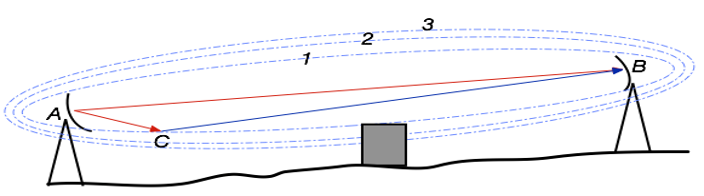
<br>
Source: https://en.wikipedia.org/wiki/Fresnel_zone

In [26]:
def calculate_fresnel(x1, y1, x2, y2, frequency, num_points):
    """
    Calculate the shape of the first Fresnel zone for a pair of antennas.

    Parameters:
    x1, y1 : float
        Coordinates of the first antenna in meters.
    x2, y2 : float
        Coordinates of the second antenna in meters.
    frequency : float
        Frequency of the signal in GHz.
    num_points : int
        Number of points to use to approximate the shape of the Fresnel zone.

    Returns:
    x, y : numpy arrays
        x-coordinates and y-coordinates of the points defining the shape of the Fresnel zone.
    """
    # Convert frequency to Hz and set the speed of light in m/s
    fr = frequency * 1e9
    c = 2.997925e8

    # Calculate the wavelength and major/minor axes of the Fresnel zone
    wavelength = c / fr
    a = 0.5 * np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r = np.sqrt(wavelength * a) / 2

    # Generate N points on the ellipse
    angles = np.linspace(0, 2*np.pi, num_points)
    X = a * np.cos(angles)
    Y = r * np.sin(angles)

    # Rotate and translate the ellipse to align with the line connecting the antennas
    angle = np.arctan2(y2 - y1, x2 - x1)
    x = X * np.cos(angle) - Y * np.sin(angle) + (x1 + x2) / 2
    y = X * np.sin(angle) + Y * np.cos(angle) + (y1 + y2) / 2

    return x, y, r

In [27]:
def check_visibility(srtm1_data: Srtm1HeightMapCollection, lat1, lon1, height1, lat2, lon2, height2, return_data=False):
    """
    Calculates the line-of-sight (LOS) visibility between two points using SRTM data.

    Args:
        srtm1_data (Srtm1HeightMapCollection): Collection of SRTM1 height maps, used to retrieve elevation data along the path.
        lat1 (float): Latitude of the starting point.
        lon1 (float): Longitude of the starting point.
        height1 (float): Height of the starting point above ground level.
        lat2 (float): Latitude of the ending point.
        lon2 (float): Longitude of the ending point.
        height2 (float): Height of the ending point above ground level.
        return_data (bool): If True, returns a DataFrame with detailed line-of-sight data. Default is False.

    Returns:
        bool or DataFrame: True if line of sight exists between the points; False otherwise.
                           If return_data is True, returns a DataFrame with line-of-sight height, elevation, and distance profiles.
    """

    # Obtain the elevation and distance profiles between the two points
    # The elevation profile provides terrain heights along the path, and distance measures the segment lengths
    e_profile, d_profile = zip(
        *[(i.elevation, i.distance) for i in srtm1_data.get_elevation_profile(lat1, lon1, lat2, lon2)]
    )

    # Handle extreme elevation values by setting values above 65,000 meters (typical for error codes) to below sea level
    e_profile = list(map(lambda x: x - 65535 if x > 65000 else x, e_profile))

    # Calculate line-of-sight profile based on heights at both points
    # The LOS profile linearly interpolates between the heights of the two points along the distance profile
    los_profile = np.linspace(e_profile[0] + height1, e_profile[-1] + height2, len(e_profile))

    # Check if the LOS profile stays above the elevation profile along the entire path
    has_line_of_sight = np.all(los_profile >= e_profile)

    if return_data:
        # If requested, return both the LOS visibility result and a DataFrame with details of each profile point
        return has_line_of_sight, pd.DataFrame(
            zip(los_profile, e_profile, d_profile), columns=['line_of_sight_height', 'elevation', 'distance']
        )

    return has_line_of_sight

The data table we generate below contains the following columns:

| Column               | Description                                             | Example        |
|---------------------|---------------------------------------------------------|----------------|
| index               | Point number along the path from school to tower        | 0, 1, 2, ...   |
| line_of_sight_height| Height of imaginary straight line between antennas (m)  | 1250.5         |
| elevation           | Ground height at each point (m)                         | 1100.2         |
| distance            | Distance from school to this point (m)                  | 2500.0         |

In [28]:
first_tower = tower_match.iloc[0]

In [29]:
has_line_of_sight, los_data = check_visibility(srtm1_data,
                                               sample_school_gdf["lat"].squeeze(),
                                               sample_school_gdf["lon"].squeeze(),
                                               sample_school_gdf["height"].squeeze(),
                                               first_tower.lat,
                                               first_tower.lon,
                                               first_tower.antenna_height,
                                               return_data = True)

In [30]:
los_data.head()

,line_of_sight_height,elevation,distance
0,528.864038,513.864038,4.612271
1,525.456143,512.871924,43.050757
2,522.048248,514.877392,70.706887
3,518.640353,518.884882,108.984249
4,515.232458,526.892126,147.964446


### Plot visibility profile for sample school and tower pair

In [31]:
def plot_visibility_profile(srtm1_data, lat1, lon1, height1, lat2, lon2, height2, signal_frequency: float = 2.4):
    """
    Plots the visibility profile between two points, showing elevation, line of sight, and Fresnel zone.

    Args:
        srtm1_data (Srtm1HeightMapCollection): Collection of SRTM1 height maps for elevation data.
        lat1 (float): Latitude of the starting point.
        lon1 (float): Longitude of the starting point.
        height1 (float): Height above ground of the starting point.
        lat2 (float): Latitude of the ending point.
        lon2 (float): Longitude of the ending point.
        height2 (float): Height above ground of the ending point.
        signal_frequency (float): Frequency in GHz to calculate the Fresnel zone radius. Default is 2.4 GHz.

    Returns:
        go.Figure: A Plotly figure showing the visibility profile.
    """

    # Perform visibility check and retrieve DataFrame with elevation profile and distances
    has_line_of_sight, df_elev = check_visibility(
        srtm1_data, lat1, lon1, height1, lat2, lon2, height2, return_data=True
    )

    # Set up the start and end coordinates for plotting
    x_start, x_end = df_elev['distance'].iloc[[0, -1]]
    y_start, y_end = df_elev['elevation'].iloc[[0, -1]]
    min_elevation = df_elev['elevation'].min()  # Minimum elevation to position fill boundaries

    # Calculate Fresnel zone radius along the path
    fresnel_x, fresnel_y, fresnel_r = calculate_fresnel(
        x_start, y_start + height1, x_end, y_end + height2, signal_frequency, len(df_elev)
    )

    # Initialize the Plotly figure
    fig = go.Figure()

    # Add the terrain elevation profile as a line plot
    fig.add_trace(go.Scatter(
        x=df_elev['distance'], y=df_elev['elevation'],
        mode='lines', name='Elevation Profile',
        line=dict(color='#e5e3df', width=2), showlegend=False
    ))

    # Add a fill area below the entire plot for visual context
    fig.add_trace(go.Scatter(
        x=[x_start, x_end], y=[min_elevation - 30, min_elevation - 30],
        mode='lines', name='', line=dict(color='#17BECF', width=0.1),
        fill='tonextx', fillcolor='rgba(229, 227, 223, 0.2)', showlegend=False
    ))

    # Plot the line of sight (LOS) between the two points
    fig.add_trace(go.Scatter(
        x=[x_start, x_end], y=[y_start + height1, y_end + height2],
        mode='lines', name='Line of Sight',
        line=dict(color='#EF553B', width=1)
    ))

    # Indicate the starting point with a vertical line and marker
    fig.add_trace(go.Scatter(
        x=[x_start, x_start], y=[y_start, y_start + height1],
        mode='lines', name='', line=dict(color='#FECB52'), showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[x_start], y=[y_start + height1],
        mode='markers', name='Location 1', marker_color='#FECB52'
    ))

    # Indicate the ending point with a vertical line and marker
    fig.add_trace(go.Scatter(
        x=[x_end, x_end], y=[y_end, y_end + height2],
        mode='lines', name='', line=dict(color='#17BECF'), showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[x_end], y=[y_end + height2],
        mode='markers', name='Location 2', marker_color='#17BECF'
    ))

    # Plot the Fresnel zone along the path as a dotted line
    fig.add_trace(go.Scatter(
        x=fresnel_x, y=fresnel_y,
        mode='lines', name='Fresnel Zone',
        line=dict(color='#ff9900', width=0.5, dash='dot'), showlegend=True
    ))

    # Customize figure layout for better visibility
    fig.update_layout(
        template='plotly_dark',
        legend=dict(orientation='h'),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )

    return fig

In [32]:
plot_visibility_profile(srtm1_data,
                        sample_school_gdf["lat"].squeeze(),
                        sample_school_gdf["lon"].squeeze(),
                        sample_school_gdf["height"].squeeze(),
                        first_tower.lat,
                        first_tower.lon,
                        first_tower.antenna_height,
                        signal_frequency = 2.4)

## Visibility analysis for all schools

In the final section, we perform the visibility analysis for all schools in our dataset. For each school:

1. We find all nearby towers within our maximum reach distance
2. Check line-of-sight visibility to each tower, taking into account terrain elevation
3. Record which towers are visible and at what distance
4. Assess whether a school is visible, and can be connected to a nearby cell site.

In [ ]:
# Restrict to 100 schools
algeria_schools_gdf = algeria_schools_gdf.iloc[:100,:]

In [33]:
# Initialize counter for total visibility checks performed
n_checks = 0

# Create a dictionary to store visibility results for each school
# Keys are school indices, initially set to None
visibility_dict = dict.fromkeys(algeria_schools_gdf.index)

# Iterate through each school in the GeoDataFrame using progress bar
for school in tqdm(algeria_schools_gdf.itertuples(), total=len(algeria_schools_gdf), desc="Processing schools"):
    # Initialize entry for current school in visibility dictionary
    # Set default visibility status to False
    visibility_dict.update({
        school.Index: dict(is_visible = False)
    })

    # Find all cell towers within maximum reach distance of the school
    # Returns tower indices and their distances from the school
    neighbors, dist_km = bubble_towers(
        kdtree,                          # KD-tree of tower locations
        np.array([school.lon, school.lat]), # School coordinates
        max_tower_reach.value            # Maximum distance to check
    )

    # Skip to next school if no towers are within range
    if neighbors is None:
        continue

    # Convert single tower index to list format for consistent processing
    # This handles edge case where only one tower is within range
    if isinstance(neighbors, int):
        neighbors = [neighbors]

    # Create DataFrame of nearby towers with their distances
    tower_match = algeria_cellsites_gdf.iloc[neighbors].copy()
    tower_match['dist_km'] = dist_km

    # Counter for number of visible towers found for current school
    visible_count = 0

    # Check line-of-sight visibility for each nearby tower
    for twr in tower_match.itertuples():
        n_checks += 1  # Increment total visibility checks counter

        # Perform line-of-sight calculation using terrain data
        has_line_of_sight = check_visibility(
            srtm1_data,          # Terrain elevation data
            school.lat,          # School latitude
            school.lon,          # School longitude
            school.height,       # School height above ground
            twr.lat,            # Tower latitude
            twr.lon,            # Tower longitude
            twr.antenna_height   # Tower height above ground
        )

        # Increment counter if tower is visible
        visible_count += has_line_of_sight

        # If tower is visible, record its details in the visibility dictionary
        if has_line_of_sight:
            # Create unique key for this visible tower
            twr_idx = 'tower_' + str(visible_count)

            # Store tower information
            visibility_dict[school.Index].update({
                twr_idx: twr.Index,                    # Tower's unique identifier
                twr_idx + '_lat': twr.lat,            # Tower's latitude
                twr_idx + '_lon': twr.lon,            # Tower's longitude
                twr_idx + '_dist': twr.dist_km,       # Distance to school in km
                twr_idx + '_los_geom': LineString([   # Line-of-sight geometry
                    twr.geometry, school.geometry
                ])
            })

            # Stop checking more towers if we've found desired number of visible towers
            if visible_count == n_visible.value:
                break

    # Update school's visibility status (True if at least one tower is visible)
    visibility_dict[school.Index].update(is_visible = visible_count > 0)

# Print summary statistics
print('Visibility check is complete!')
print(f'Average # of checks per school: {n_checks/len(algeria_schools_gdf)}')

Processing schools: 100%|██████████| 1819/1819 [05:08<00:00,  5.90it/s]

Visibility check is complete!
Average # of checks per school: 35.995052226498075


In [34]:
df_visibility = pd.DataFrame(visibility_dict.values(), visibility_dict.keys())
df_visibility.head()

,is_visible,tower_1,tower_1_lat,tower_1_lon,tower_1_dist,tower_1_los_geom,tower_2,tower_2_lat,tower_2_lon,tower_2_dist,tower_2_los_geom,tower_3,tower_3_lat,tower_3_lon,tower_3_dist,tower_3_los_geom
297,True,1622.0,36.7757,3.7479,29.410661,"LINESTRING (3.7479 36.7757, 3.542067 36.6095942)",1623.0,36.7728,3.7506,29.445069,"LINESTRING (3.7506 36.7728, 3.542067 36.6095942)",1621.0,36.7751,3.7502,29.568551,"LINESTRING (3.7502 36.7751, 3.542067 36.6095942)"
298,True,653.0,36.7164,3.4104,1.849264,"LINESTRING (3.4104 36.7164, 3.4269972 36.7153429)",285.0,36.7270,3.4075,2.525934,"LINESTRING (3.4075 36.727, 3.4269972 36.7153429)",1184.0,36.7528,3.4656,5.981016,"LINESTRING (3.4656 36.7528, 3.4269972 36.7153429)"
299,True,2132.0,36.7232,3.3686,3.675390,"LINESTRING (3.3686 36.7232, 3.3743675 36.6906535)",2152.0,36.7239,3.3702,3.725773,"LINESTRING (3.3702 36.7239, 3.3743675 36.6906535)",544.0,36.7242,3.3689,3.779419,"LINESTRING (3.3689 36.7242, 3.3743675 36.6906535)"
300,True,1767.0,36.6601,3.3396,4.042879,"LINESTRING (3.3396 36.6601, 3.365916 36.685188)",2132.0,36.7232,3.3686,4.237265,"LINESTRING (3.3686 36.7232, 3.365916 36.685188)",284.0,36.6642,3.3337,4.275393,"LINESTRING (3.3337 36.6642, 3.365916 36.685188)"
301,True,1229.0,36.7248,3.3852,1.122647,"LINESTRING (3.3852 36.7248, 3.3949279 36.7220979)",1209.0,36.7254,3.3772,2.005157,"LINESTRING (3.3772 36.7254, 3.3949279 36.7220979)",1216.0,36.7254,3.3765,2.081726,"LINESTRING (3.3765 36.7254, 3.3949279 36.7220979)"


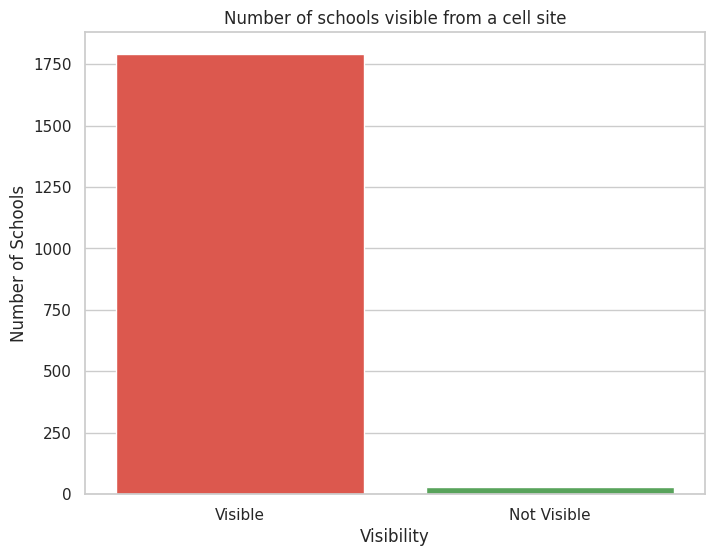

In [35]:
# Create visibility counts visualization
sns.set(style="whitegrid")
visibility_counts = df_visibility["is_visible"].value_counts().rename_axis("Visibility").reset_index(name="Count")
visibility_counts["Visibility"] = visibility_counts["Visibility"].map({True: "Visible", False: "Not Visible"})

plt.figure(figsize=(8, 6))
sns.barplot(
    x="Visibility",
    y="Count",
    hue="Visibility",
    data=visibility_counts,
    palette=["#F44336", "#4CAF50"],
    legend=False
)

plt.title("Number of schools visible from a cell site")
plt.xlabel("Visibility")
plt.ylabel("Number of Schools")
plt.show()